In [1]:
import matplotlib.pyplot as plt
#plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from numpy import exp
import seaborn as sns
from matplotlib import colors
import pandas as pd

In [2]:
from scipy.integrate import odeint

This code is heavily inspired by this [notebook](https://github.com/QuantEcon/lecture-python.notebooks/blob/master/sir_model.ipynb). It is the Python version of the code for analyzing the COVID-19 pandemic provided by [Andrew Atkeson](https://sites.google.com/site/andyatkeson/).
See, in particular:

- [NBER Working Paper No. 26867](https://www.nber.org/papers/w26867)  
- [COVID-19 Working papers and code](https://sites.google.com/site/andyatkeson/home?authuser=0)  

## Init conditions

In [35]:
pop_size = 10000
γ = 1 / 2.9
σ = 1 / 5.2

# initial conditions of s, e, i
i_0 = (5/pop_size)
e_0 = 0
s_0 = 1 - i_0 - e_0
print(i_0, e_0, s_0)
x_0 = s_0, e_0, i_0 # vector initial condition

0.0005 0 0.9995


In [36]:
def F(x, t, R0=1.6):
    """
    Time derivative of the state vector.

        * x is the state vector (array_like)
        * t is time (scalar)
        * R0 is the effective transmission rate, defaulting to a constant

    """
    s, e, i = x

    # New exposure of susceptibles
    β = R0(t) * γ if callable(R0) else R0 * γ
    ne = β * s * i

    # Time derivatives
    ds = - ne
    de = ne - σ * e
    di = σ * e - γ * i

    return ds, de, di

In [37]:
def solve_path(R0, t_vec, x_init=x_0):
    """
    Solve for i(t) and c(t) via numerical integration,
    given the time path for R0.

    """
    G = lambda x, t: F(x, t, R0)
    s_path, e_path, i_path = odeint(G, x_init, t_vec).transpose()

    c_path = 1 - s_path - e_path       # cumulative cases
    r_path = 1 - s_path - e_path - i_path
    return s_path, e_path, i_path, r_path, c_path

In [38]:
t_length = 100
grid_size = 100
t_vec = np.linspace(0, t_length, grid_size)

In [39]:
R0_vals = np.linspace(1.3, 5.0, 20)
labels = [f'$R0 = {r:.2f}$' for r in R0_vals]
s_paths, e_paths, i_paths, c_paths, r_paths = [], [], [], [], []

for r in R0_vals:
    s_path, e_path, i_path, r_path, c_path = solve_path(r, t_vec)

    s_paths.append(s_path)
    e_paths.append(e_path)
    i_paths.append(i_path)
    r_paths.append(r_path)
    c_paths.append(c_path)

In [55]:
r0 = 12

R0 used is:  3.636842105263158


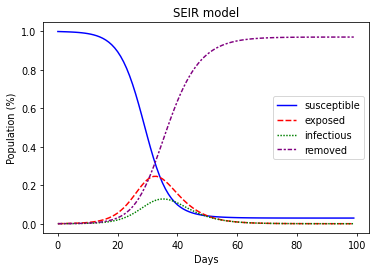

In [88]:
simulation = pd.DataFrame({"susceptible":s_paths[r0], "exposed":e_paths[r0], 
        "infectious":i_paths[r0], "removed":r_paths[r0]})
pd_stats = simulation

color_list = ["blue","red","green","purple"]
cmap = colors.LinearSegmentedColormap.from_list("", color_list)
fig, ax = plt.subplots(figsize=(6,4), dpi=70)
sns.lineplot(ax=ax,data=pd_stats,palette=color_list ).set(title = 'SEIR model', xlabel = 'Days', ylabel = 'Population (%)')
print("R0 used is: ", R0_vals[r0])

## Lockdown

In [ ]:
def R0_mitigating(t, r0=3.83, η=1, r_bar=1.6):
    R0 = r0 * exp(- η * t) + (1 - exp(- η * t)) * r_bar
    return R0

In [89]:
# initial conditions
lockdown_at = 25
lockdown_dur = 14
R0_paths = (lambda t: 1.75 if t >= lockdown_at and t <= lockdown_at+lockdown_dur else 3.636)

In [90]:
s_path, e_path, i_path, r_path, c_path = solve_path(R0_paths, t_vec)

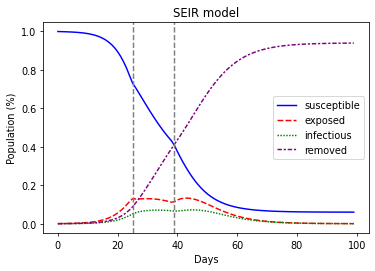

In [91]:
simulation = pd.DataFrame({"susceptible":s_path, "exposed":e_path, 
        "infectious":i_path, "removed":r_path})
pd_stats = simulation

color_list = ["blue","red","green","purple"]
cmap = colors.LinearSegmentedColormap.from_list("", color_list)
fig, ax = plt.subplots(figsize=(6,4), dpi=70)
sns.lineplot(ax=ax,data=pd_stats,palette=color_list ).set(title = 'SEIR model', xlabel = 'Days', ylabel = 'Population (%)')
plt.axvline(25, linestyle="--", color="gray")
plt.axvline(25+14, linestyle="--", color="gray")